### Boosted Tree Classification Model
In this tutorial, we show you the steps to train a boosted tree classification model, how to evaluate this model afterwards and how to do hyperparameter search so we can find the best model. 

We train the model using two versions of the London dataset: one with all records from all classes (which we call "full" dataset) and another with classes 0, 1 and 2 undersampled. We do so to understand the impact of class imbalance in the model's performance.

### 1. Import libraries
First of all, we import xgboost, the library which provides boosted tree functionality. The purpose other libraries will be explained as we advance in the tutorial.

In [4]:
import pickle
import xgboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

stats_map = {}
def recordStats(report_obj):
    new_obj = {}
    new_obj['macro_f1'] = report_obj['macro avg']['f1-score']
    new_obj['weighted_f1'] = report_obj['weighted avg']['f1-score']
    new_obj['class_0'] = report_obj['0']['f1-score']
    new_obj['class_1'] = report_obj['1']['f1-score']
    new_obj['class_2'] = report_obj['2']['f1-score']
    new_obj['class_3'] = report_obj['3']['f1-score']
    new_obj['class_4'] = report_obj['4']['f1-score']
    new_obj['class_5'] = report_obj['5']['f1-score']
    return new_obj

### 2. Load data
We use Pandas to load the preprocessed versions of two datasets: the full version (london_clean.csv) and the undersampled version (london_clean_undersample.csv).

In [5]:
ds = pd.read_csv('preprocessing/data/london_clean.csv')
dsu = pd.read_csv('preprocessing/data/london_clean_undersample.csv')

### 3. Split data
We start working with the full dataset. After loading the data, we select only the columns we will use for training the model. We are aware the unecessary columns could have been removed in the preprocessing phase, but we chose to keep them in the file so we can experiment with different combination of inputs/output

We split the dataset between columns that will be used as input to train the model (X) and the actual output (y). In other words, for a certain combination of data about the file (e.g. data of call, property type, etc.) we want to predict its cost category.

Besides splitting columns, we also want to split the rows to create two datasets: one for training (70% of the original dataset rows) and testing (30% of the original dataset rows). We use train_test_split from scikit-learn to do this task for us.

In [6]:
selected_cols = ["DateOfCall", "PropertyType", "NumPumpsAttending", 
                    "PumpHoursRoundUp", "CostCat", "mean_temp"]
ds = ds.loc[:, selected_cols]

X = ds.drop(["CostCat"], axis=1).values 
y = ds["CostCat"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### 4. Train model (full dataset)
We call xgboost.XGBClassifier and use the training dataset (x_train, y_train) to train the model. We use the hyperparameter objective="multi:softmax" because we want to do multiclass classification. We keep the other hyperparameters in their default values. Later, in step 6, we will try different hyperparameter combinations to find the best one.

In [7]:
model = xgboost.XGBClassifier(objective="multi:softmax", random_state=42)
model = model.fit(X_train, y_train)

### 5. Evaluate model (full dataset)
We use the trained model to make predictions. We then compare these predictions to the actual labels to check how accurate is the model. According to sci-kit learn's classification_report, the weighter average f1-score is 0.78.

Default Boosted Tree Model Description
*******************************************
Classification Report of the Default Model
              precision    recall  f1-score   support

           0       0.75      0.90      0.82    231390
           1       0.75      0.49      0.60    140418
           2       1.00      1.00      1.00     34444
           3       0.71      0.90      0.79      5421
           4       0.71      0.44      0.55      4962
           5       0.91      0.96      0.93      7949

    accuracy                           0.77    424584
   macro avg       0.81      0.78      0.78    424584
weighted avg       0.77      0.77      0.76    424584



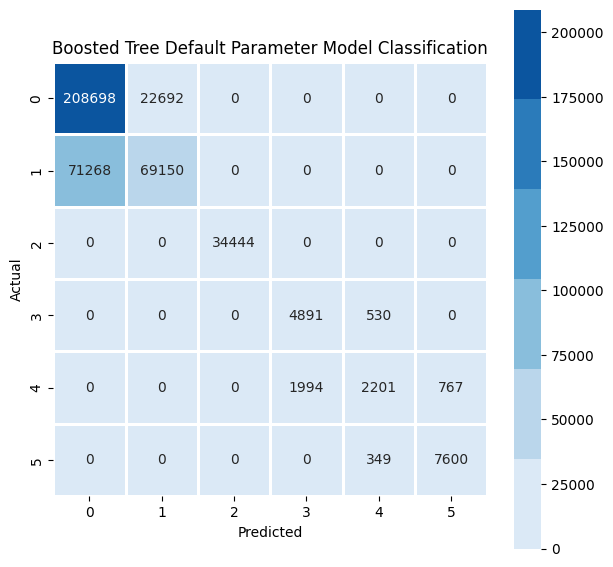

In [10]:
y_pred = model.predict(X_test).round()

# test
print("Default Boosted Tree Model Description")
print("*******************************************")
print("Classification Report of the Default Model")
report = classification_report(y_test, y_pred)
print(report)

# visualizing classification report
cmap =sns.color_palette("Blues")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Boosted Tree Default Parameter Model Classification")
plt.show()

In [13]:
# saving the values to export them later
report = classification_report(y_test, y_pred, output_dict=True)
stats_map["BT_default_full"] = recordStats(report)

{'BT_default_full': {'macro_f1': 0.7809300971180204,
  'weighted_f1': 0.7568813813776981,
  'class_0': 0.8162532560486236,
  'class_1': 0.5954533712219064,
  'class_2': 1.0,
  'class_3': 0.7948967983097676,
  'class_4': 0.5473762745585675,
  'class_5': 0.9316008825692572}}

### 6. Hyperparameter tuning (full dataset)
ATTENTION: the code below may take a long time to run and consume a large amount of CPU/RAM from your system.

After training the model successfully with default hyperparameters, we want to test other hyperameters as well to determine if the model can be improved, or if the results we got are the best possible for this combination of tree-method and dataset. 

First of all we need to know what are the hyperparameters used in the default run of the algorithm. According to the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster), the defaults are:
- max_depth: 6
- tree_method: 'auto'
- n_estimators: the default is 'none', meaning that this value can grow as much as needed. For the model we just trained, the value obtained is 100

We used GridSearchCV to search for the best combination of hyperparameters for training a boosted tree. We chose the range of hyperparams in tree_params based on step 6. We chose values that are bit larger/smaller than the defaults so we can check if adjustments to these values cause some kind of improvement.

After the search is done, it gives us the model that it found to be the best: x. We save it in pickle format so we can load it later to re-evaluate it or generate predictions. 

We also convert the cv_results_ object into a JSON file, which we use to create the visualizations seen in step 7. 

GridSearchCV also does cross-validation (here we used 5 splits, the default).

In [21]:
select_params = {'n_estimators': [75, 100, 125], 
               'max_depth': [3, 6, 9], 
               'tree_method': ['auto', 'exact', 'approx', 'hist']}
model_best = GridSearchCV(xgboost.XGBClassifier(), select_params, n_jobs=4, cv=5)
model_best = model_best.fit(X_train, y_train)

# save in pickle format
pickle.dump(model, open('test_results/boosted_trees_best_full.pickle', "wb"))

print("The best hyperparameter found in this search are:", model_best.best_params_)

{'max_depth': 10, 'n_estimators': 100, 'tree_method': 'exact'}


#### 7. Best Performing Model
According to sci-kit learn's classification_report, the weighted average f1-score is 0.80. This is an improvement of 0.02 in comparison with the default hyperparameters.

We can use a confusion matrix to visualize the count of classifications and misclassifications for each category. Category 4 was the most frequently misclassified.


Boosted Trees - Classification Report
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     20861
           1       0.73      0.58      0.65     12791
           2       1.00      1.00      1.00      9264
           3       0.74      0.85      0.80      4977
           4       0.69      0.55      0.62      4712
           5       0.92      0.94      0.93      7398

    accuracy                           0.81     60003
   macro avg       0.81      0.80      0.80     60003
weighted avg       0.81      0.81      0.80     60003



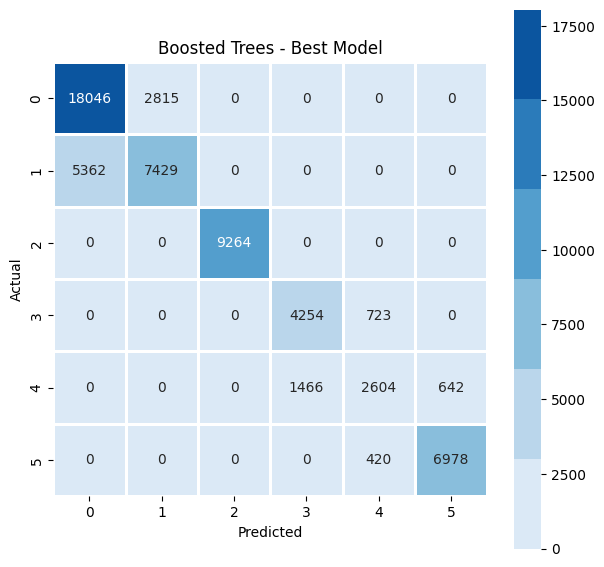

In [40]:
y_top_pred = model_best.predict(X_test)
print("Boosted Trees - Classification Report")
report = classification_report(y_test, y_top_pred)
print(report)

# visualizing classification report
cmap = sns.color_palette("Blues")
cm = confusion_matrix(y_test, y_top_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap=cmap,
    annot_kws={"fontsize": 10},
    linewidth=1,
    square=True,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Boosted Trees - Best Model")
plt.show()

In [14]:
report = classification_report(y_test, y_top_pred, output_dict=True)
stats_map["BT_best_full"] = recordStats(report)

### 8. Work with the Undersampled Dataset
We now repeat steps 3, 4, 5 and 6 (train, evaluation and hyperparameter search) with the undersampled dataset.

### 8.1 Split data

In [15]:
selected_cols = ["DateOfCall", "PropertyType", "NumPumpsAttending", 
                    "PumpHoursRoundUp", "CostCat", "mean_temp"]
dsu = dsu.loc[:, selected_cols]
X = dsu.drop(["CostCat"], axis=1).values 
y = dsu["CostCat"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### 8.2 Train Model

In [16]:
model = xgboost.XGBClassifier(objective="multi:softmax", random_state=42)
model = model.fit(X_train, y_train)

### 8.3 Evaluate Model

Undersampled Boosted Tree Model Description
*******************************************
Classification Report of the Undersampled Model
              precision    recall  f1-score   support

           0       0.73      0.90      0.81     22940
           1       0.74      0.45      0.56     14064
           2       1.00      1.00      1.00     10240
           3       0.70      0.91      0.79      5454
           4       0.73      0.44      0.55      5179
           5       0.91      0.96      0.93      8126

    accuracy                           0.79     66003
   macro avg       0.80      0.78      0.77     66003
weighted avg       0.79      0.79      0.78     66003



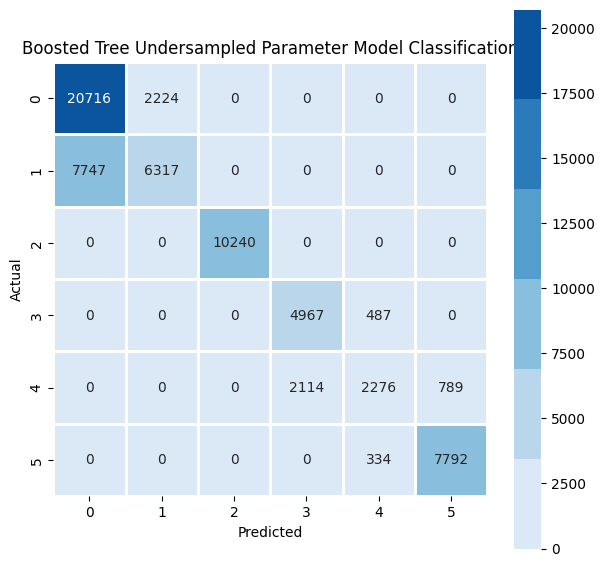

In [18]:
y_pred = model.predict(X_test).round()

# test
print("Undersampled Boosted Tree Model Description")
print("*******************************************")
print("Classification Report of the Undersampled Model")
report = classification_report(y_test, y_pred)
print(report)

# visualizing classification report
cmap =sns.color_palette("Blues")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Boosted Tree Undersampled Parameter Model Classification")
plt.show()

In [20]:
# saving the values to export them later
report = classification_report(y_test, y_pred, output_dict=True)
stats_map["BT_default_under"] = recordStats(report)

{'BT_default_full': {'macro_f1': 0.7809300971180204,
  'weighted_f1': 0.7568813813776981,
  'class_0': 0.8162532560486236,
  'class_1': 0.5954533712219064,
  'class_2': 1.0,
  'class_3': 0.7948967983097676,
  'class_4': 0.5473762745585675,
  'class_5': 0.9316008825692572},
 'BT_best_full': {'macro_f1': 0.7809300971180204,
  'weighted_f1': 0.7568813813776981,
  'class_0': 0.8162532560486236,
  'class_1': 0.5954533712219064,
  'class_2': 1.0,
  'class_3': 0.7948967983097676,
  'class_4': 0.5473762745585675,
  'class_5': 0.9316008825692572},
 'BT_default_under': {'macro_f1': 0.773372286962665,
  'weighted_f1': 0.7778623000620029,
  'class_0': 0.8060229947668425,
  'class_1': 0.5589028975890291,
  'class_2': 1.0,
  'class_3': 0.7925009972078181,
  'class_4': 0.5500241662638956,
  'class_5': 0.9327826659484049}}

### 8.4 Hyperparameter Search

In [21]:
select_params = {'n_estimators': [75, 100, 125], 
               'max_depth': [3, 6, 9], 
               'tree_method': ['auto', 'exact', 'approx', 'hist']}
model_best = GridSearchCV(xgboost.XGBClassifier(), select_params, n_jobs=4, cv=5)
model_best = model_best.fit(X_train, y_train)

# save in pickle format
pickle.dump(model, open('test_results/boosted_trees_best_und.pickle', "wb"))

print("The best hyperparameter found in this search are:", model_best.best_params_)

The best hyperparameter found in this search are: {'max_depth': 9, 'n_estimators': 125, 'tree_method': 'auto'}


### 8.5 Best Performing Model

Undersampled Boosted Tree Model Description
*******************************************
Classification Report of the Undersampled Model
              precision    recall  f1-score   support

           0       0.73      0.90      0.81     22940
           1       0.74      0.45      0.56     14064
           2       1.00      1.00      1.00     10240
           3       0.70      0.91      0.79      5454
           4       0.73      0.44      0.55      5179
           5       0.91      0.96      0.93      8126

    accuracy                           0.79     66003
   macro avg       0.80      0.78      0.77     66003
weighted avg       0.79      0.79      0.78     66003



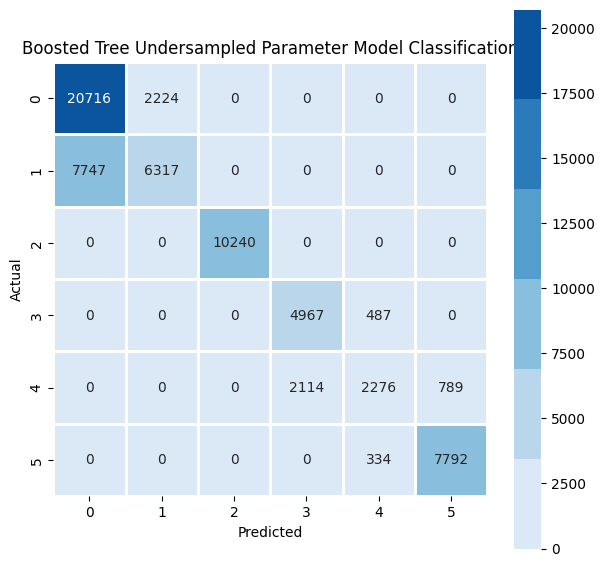

In [23]:
y_pred = model.predict(X_test).round()

# test
print("Undersampled Boosted Tree Model Description")
print("*******************************************")
print("Classification Report of the Undersampled Model")
report = classification_report(y_test, y_pred)
print(report)

# visualizing classification report
cmap =sns.color_palette("Blues")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, 
            annot_kws={'fontsize':10}, linewidth=1, square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Boosted Tree Undersampled Parameter Model Classification")
plt.show()

In [24]:
# saving the values to export them later
report = classification_report(y_test, y_pred, output_dict=True)
stats_map["BT_best_under"] = recordStats(report)

### 10. Conclusions
This model provides a weighted average f1-score of 0.78 when trained with default hyperparameters. By doing hyperparameter tunning, we managed to improve the weighted average f1-score from 0.78 to 0.80. Considering that the goal of the project is simply showing the viability of firefighting cost prediction by using this kind of tree-based model, the accuracy score we obtained is satisfactory.